In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(800_000_000_000)

from calitp_data_analysis.tables import tbls

from siuba import *
import pandas as pd
import geopandas as gpd

import datetime as dt
from rt_analysis import signal_tools, rt_filter_map_plot

# Signal Transit Scoring

We used three scoring components for each signal: a speed component, speed variability component, and transit frequency component. Each component is scored 0-10, and the overall transit score is a sum of all three. Higher numbers indicate more delay, more unreliability, and more frequent transit, so based on our analysis the signals with the highest combined scores would be the place to start.

Subscores are calculated seperately for all transit routes approaching a signal. To get the overall signal score, we sum the medians of all three subscores for that signal.

In [2]:
path = './signals_2024-01-16.xlsx'
signal_gdf = signal_tools.read_signal_excel(path)

In [3]:
signal_gdf >> head(3)

,legacy_district_tms_id,detection_technology,funded,funded.1,user_program_type,am_tool_tms_worksheet::program_type,user_program_type.1,user_rtl,user_rtl.1,am_tool_tms_worksheet::rtl_plan_year,...,crosswalks_lpi_implemented,crosswalks_lpi_implemented_date,crosswalks_lpi_implemented_exception_comments,tms_unit_tech_projected_age,tms_id,am_tool_tms_worksheet::comments,owned_by,operated_by,maintained_by,geometry
0,01DN101-E2590,NaN,Yes,Yes,HM,HM,HM,2024.0,2024.0,2025.0,...,None,NaT,NaN,-1,0110102584PA,chronic http://sv03tmctrac/projects/tms_suppor...,Caltrans(District),Caltrans(District),Caltrans(District),POINT (-124.18538 41.75222)
1,01DN101-E2627,NaN,Yes,Yes,SHOPP,SHOPP,SHOPP,2031.0,2031.0,2031.0,...,None,NaT,NaN,-1,0110102627PS,NaN,Caltrans(District),Caltrans(District),Caltrans(District),POINT (-124.19306 41.75281)
2,01DN101-E2640,NaN,Yes,Yes,SHOPP,SHOPP,SHOPP,2031.0,2031.0,2031.0,...,None,NaT,NaN,-1,0110102642PN,NaN,Caltrans(District),Caltrans(District),Caltrans(District),POINT (-124.19447 41.75575)


# Rebuild analysis with latest speedmap data

* switch to new speed data pending
* sbmtd not available due to a feed upload gap, use last date

In [4]:
progress_df = pd.read_parquet('./_rt_progress_2023-11-15.parquet') >> filter(_.status == 'map_confirmed')

In [5]:
analysis_date = progress_df.analysis_date.iloc[0]

In [6]:
# all_segment_gdf = signal_tools.concatenate_speedmap_segments(progress_df=progress_df)

In [7]:
progress_df >> filter(_.organization_itp_id == 293)

,organization_name,organization_itp_id,organization_source_record_id,caltrans_district,_is_current,analysis_date,status
19,Santa Barbara Metropolitan Transit District,293,recswCrw6a6htmXJ4,05 - San Luis Obispo,True,2023-11-15,map_confirmed


In [8]:
import shared_utils

In [9]:
# ## use September run for SBMTD (data gap)

# rt_day = rt_filter_map_plot.from_gcs(293, dt.date(2023, 9, 13), pbar)

# _m = rt_day.segment_speed_map(how='low_speeds', no_title=True, shn=True,
#                      no_render=True
#                     )

# dmv_proj = rt_day.detailed_map_view.to_crs(shared_utils.geography_utils.CA_NAD83Albers)
# # re-add some identifiers since we won't have the instance handy
# # dmv_proj['feed_key'] = rt_day.rt_trips.feed_key.iloc[0]
# dmv_proj['gtfs_dataset_key'] = rt_day.rt_trips.gtfs_dataset_key.iloc[0]
# dmv_proj['organization_name'] = rt_day.organization_name
# dmv_proj['system_p50_median'] = dmv_proj.p50_mph.quantile(.5)

In [10]:
# all_segment_gdf = pd.concat([all_segment_gdf, dmv_proj])

In [11]:
# all_segment_gdf.to_parquet(f'segments_all_{analysis_date}.parquet')

In [12]:
# segment_lines_all = signal_tools.copy_segment_speeds(progress_df, date_exceptions = {293: dt.date(2023, 9, 13)})

In [13]:
# segment_lines_all.to_parquet(f'./segment_lines_all_{analysis_date}.parquet')

In [14]:
segments_all = gpd.read_parquet(f'segments_all_{analysis_date}.parquet')

<AxesSubplot:>

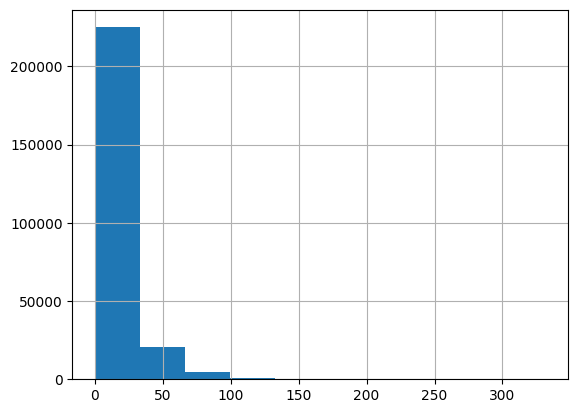

In [50]:
segments_all

In [15]:
segment_lines_all = gpd.read_parquet(f'./segment_lines_all_{analysis_date}.parquet')

In [16]:
joined_seg_lines = signal_tools.sjoin_signals(signal_gdf = signal_gdf, segments_gdf = segments_all,
                                              segments_lines_gdf = segment_lines_all)

In [17]:
joined_seg_lines = signal_tools.determine_approaching(joined_seg_lines)

In [18]:
median_by_signal = signal_tools.calculate_scores(joined_seg_lines)

In [19]:
median_by_signal >> arrange(-_.overall_transit_score)

,imms_id,location,speed_score,variability_score,frequency_score,overall_transit_score
2184,07LA110 -ED436,OFF 2ND STREET -BEAUDRY AVENUE,8.0,10.0,10.0,28.0
1142,04SM084 -E35C0,BROADWAY/S/B 101 OFF-RAMP and WOODSIDE RD (RTE...,6.0,10.0,10.0,26.0
1148,04SM084 -E35D1,VETERANS/S/B 101 ON-RAMP and WOODSIDE RD (RTE 84),6.0,10.0,10.0,26.0
3343,12ORA055 -E0176,55 at Santiago Blvd / Lincoln Ave,6.0,10.0,10.0,26.0
868,04SCL237 -EZ374,MATHILDA AVE and RTE 237 E/B RAMPS,5.0,10.0,10.0,25.0
...,...,...,...,...,...,...
2867,10STA099R-EC069,Fulkerth Road,0.0,3.0,1.0,4.0
2868,10STA099R-EC082,W. Main Street,0.0,3.0,1.0,4.0
3090,11SD094 -E8005,DAISY DR,1.0,3.0,0.0,4.0
3094,11SD094 -E8305,COUGAR CANYON DR /STEELE CANYON HS,0.0,3.0,0.0,3.0


## Reference Histograms for subscores

<AxesSubplot:>

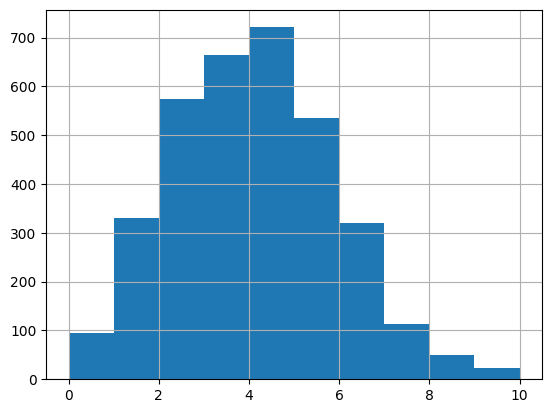

In [20]:
median_by_signal.speed_score.hist()

<AxesSubplot:>

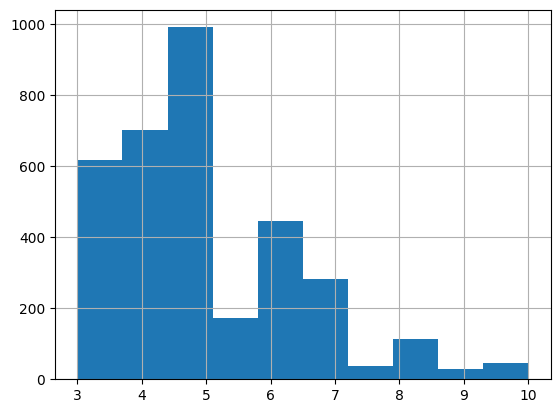

In [21]:
median_by_signal.variability_score.hist()

<AxesSubplot:>

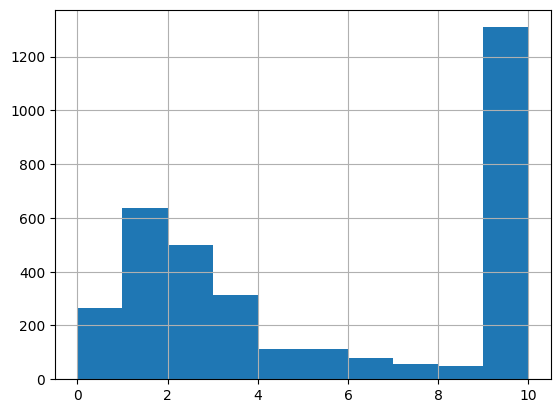

In [22]:
median_by_signal.frequency_score.hist()

<AxesSubplot:>

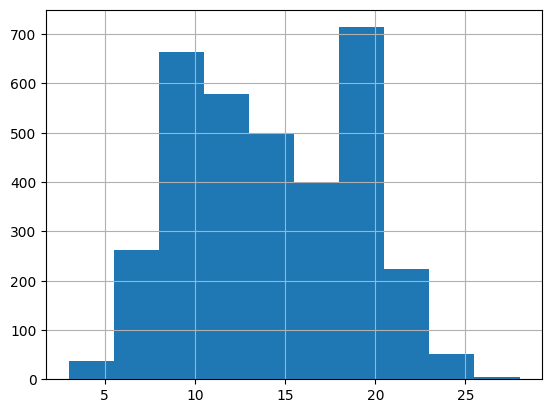

In [23]:
median_by_signal.overall_transit_score.hist()

In [24]:
median_by_signal.imms_id

2184     07LA110 -ED436
1142     04SM084 -E35C0
1148     04SM084 -E35D1
3343    12ORA055 -E0176
868     04SCL237 -EZ374
             ...       
2867    10STA099R-EC069
2868    10STA099R-EC082
3090     11SD094 -E8005
3094     11SD094 -E8305
3101     11SD094 -E8772
Name: imms_id, Length: 3430, dtype: object

In [25]:
median_by_signal['dist'] = median_by_signal.imms_id.map(lambda x: x[:2] if not pd.isna(x) else x)

In [26]:
median_by_signal >> count(_.dist)

,dist,n
0,01,48
1,02,45
2,03,172
3,04,1050
4,05,181
5,06,136
6,07,914
7,08,279
8,09,3
9,10,109


In [27]:
median_by_signal.to_excel('signals_transit_score_jan_16_2023.xlsx')

In [28]:
gdf = (signal_gdf >> select(_.imms_id, _.geometry)) >> inner_join(_, median_by_signal, on = 'imms_id')

In [29]:
# (signal_gdf >> filter(_.imms_id.str.contains('04SF101')) >> select(_.imms_id, _.location, _.geometry)).explore()

In [30]:
# gdf.explore(column = 'overall_transit_score', tiles = 'CartoDB positron', cmap='Blues')

In [31]:
import branca

In [32]:
signal_colorscale = branca.colormap.step.Purples_05.scale(vmin=0, vmax=gdf.overall_transit_score.max())

In [33]:
from shared_utils import rt_utils

In [34]:
gdf = gdf.to_crs(shared_utils.geography_utils.CA_NAD83Albers)
gdf.geometry = gdf.buffer(100)

A full state speedmap sort of works, but I suspect loading it and another layer at once hits some sort of GTFS limit...

In [37]:
sig_speeds = joined_seg_lines >> filter(_.approaching)

In [38]:
segments_all.shape

(251676, 18)

In [39]:
sig_speeds.shape

(40835, 23)

In [41]:
sig_speeds.columns

Index(['stop_id', 'stop_name', 'geometry', 'shape_id', 'stop_sequence',
       'route_id', 'route_short_name', 'direction_id', 'p50_mph', 'p20_mph',
       'p80_mph', 'fast_slow_ratio', 'trips_per_hour', 'miles_from_last',
       'time_formatted', 'gtfs_dataset_key', 'organization_name',
       'system_p50_median', 'imms_id', 'location', 'signal_pt_geom',
       'line_geom', 'approaching'],
      dtype='object')

In [42]:
sig_speeds = sig_speeds >> select(-_.signal_pt_geom, -_.imms_id, -_.location, -_.line_geom, -_.approaching,
                                 -_.time_formatted, -_.gtfs_dataset_key, -_.organization_name)

In [45]:
speedmap = rt_utils.set_state_export(sig_speeds, subfolder='signals/', filename='speeds', cmap=rt_utils.ZERO_THIRTY_COLORSCALE,
                          color_col='p20_mph', cache_seconds=1, map_type='speedmap',
                         legend_url = rt_utils.SPEEDMAP_LEGEND_URL, map_title='Speeds')

writing to calitp-map-tiles/signals/speeds.geojson.gz


In [46]:
##TODO map title clash??

In [47]:
rt_utils.set_state_export(gdf, subfolder='signals/', cmap=signal_colorscale,
                          color_col='overall_transit_score', existing_state=speedmap['state_dict'],
                         map_title='Signals')

writing to calitp-map-tiles/signals/test2.geojson.gz


{'state_dict': {'name': 'null',
  'layers': [{'name': 'Speeds',
    'url': 'https://storage.googleapis.com/calitp-map-tiles/signals/speeds.geojson.gz',
    'properties': {'stroked': False,
     'highlight_saturation_multiplier': 0.5,
     'tooltip_speed_key': 'p20_mph'},
    'type': 'speedmap'},
   {'name': 'Signals',
    'url': 'https://storage.googleapis.com/calitp-map-tiles/signals/test2.geojson.gz',
    'properties': {'stroked': False, 'highlight_saturation_multiplier': 0.5}}],
  'lat_lon': (35.73358630515601, -119.83248785655391),
  'zoom': 13,
  'legend_url': 'https://storage.googleapis.com/calitp-map-tiles/speeds_legend.svg'},
 'spa_link': 'https://embeddable-maps.calitp.org/?state=eyJuYW1lIjogIm51bGwiLCAibGF5ZXJzIjogW3sibmFtZSI6ICJTcGVlZHMiLCAidXJsIjogImh0dHBzOi8vc3RvcmFnZS5nb29nbGVhcGlzLmNvbS9jYWxpdHAtbWFwLXRpbGVzL3NpZ25hbHMvc3BlZWRzLmdlb2pzb24uZ3oiLCAicHJvcGVydGllcyI6IHsic3Ryb2tlZCI6IGZhbHNlLCAiaGlnaGxpZ2h0X3NhdHVyYXRpb25fbXVsdGlwbGllciI6IDAuNSwgInRvb2x0aXBfc3BlZWRfa2V5IjogIn

TODO put on a scale and ship it!

* improve export legends script!

In [1]:
# signal_colorscale._repr_html_()

## Debug trips per hour

In [51]:
from rt_analysis import rt_filter_map_plot
from tqdm.notebook import tqdm
pbar = tqdm()

0it [00:00, ?it/s]

In [52]:
rt_filter_map_plot.from_gcs?

Signature: rt_filter_map_plot.from_gcs(itp_id, analysis_date, pbar=None)
Docstring:
Generates RtFilterMapper from cached artifacts in GCS. Generate using rt_parser.OperatorDayAnalysis.export_views_gcs()
    
File:      ~/data-analyses/rt_delay/rt_analysis/rt_filter_map_plot.py
Type:      function

In [53]:
rt_day = rt_filter_map_plot.from_gcs(4, dt.date(2023, 11, 15), pbar)

found shapes parquet at gs://calitp-analytics-data/data-analyses/rt_delay/v2_cached_views/shapes_4_2023-11-15.parquet


In [54]:
rt_day.hr_duration_in_filter

0.9786111111111111

In [57]:
time_max = rt_day.stop_delay_view.actual_time.max()
time_max

Timestamp('2023-11-16 00:59:09.858363')

In [58]:
time_min = rt_day.stop_delay_view.actual_time.min()
time_min

Timestamp('2023-11-15 00:00:26.271553')

In [65]:
time_difference = (time_max - time_min)
time_difference

Timedelta('1 days 00:58:43.586810')

In [66]:
time_difference.seconds

3523

In [67]:
time_difference.total_seconds()

89923.58681

In [ ]:
## there's your problem -- handle days

In [ ]:
self.stop_delay_view.actual_time.max() - 
                                         self.stop_delay_view.actual_time.min()).seconds / 60**2

## Provide All SHS Segments

In [ ]:
from shared_utils.rt_utils import SHN_PATH
from shared_utils.geography_utils import CA_NAD83Albers
import dask_geopandas as dg

In [ ]:
segment_lines_all >> head(3)

In [ ]:
# add line geometries from stop_segment_speed_view
seg_lines = (segment_lines_all
            >> select(_.line_geom == _.geometry, _.shape_id, _.stop_sequence, _.stop_id)
            >> distinct(_.line_geom, _.shape_id, _.stop_sequence, _.stop_id)
        )
# ideally a more robust join in the future
joined_seg_lines = segments_all >> inner_join(_, seg_lines, on = ['shape_id', 'stop_sequence', 'stop_id'])

In [ ]:
joined_seg_lines = joined_seg_lines.set_geometry('line_geom', drop = True)

In [ ]:
joined_seg_lines >> head(3)

In [ ]:
segments_all >> head(3)

In [ ]:
shs = gpd.read_parquet(SHN_PATH).to_crs(CA_NAD83Albers)

In [ ]:
shs >> head(3)

In [ ]:
shs_dask = dg.from_geopandas(shs, npartitions=10)

In [ ]:
segs_dask = dg.from_geopandas(segments_all, npartitions=10)

In [ ]:
lines_dask = dg.from_geopandas(joined_seg_lines, npartitions=10)

In [ ]:
shs_segs_joined = segs_dask.sjoin(shs_dask)

In [ ]:
shs_segs_joined_computed = shs_segs_joined.compute()

In [ ]:
shs_segs_joined_computed >> head(3)

In [ ]:
shs_lines_joined = lines_dask.sjoin(shs_dask)

In [ ]:
shs_lines_joined_computed = shs_lines_joined.compute()

In [ ]:
shs_lines_joined_computed >> head(3)

In [ ]:
shs_lines_joined_computed.columns

In [ ]:
shs_lines_joined_computed = shs_lines_joined_computed >> select(-_.time_from_last, -_.index_right, -_.highway_length,
                                                            -_.EB, -_.WB, -_.NB, -_.SB)

In [ ]:
shs_lines_joined_computed.to_file('transit_lines_shs_joined.geojson')

In [ ]:
shs_segs_joined_computed.to_file('transit_polygons_shs_joined.geojson')